### Setup

In [ ]:
import matplotlib.pyplot as plt
import torch

from src.data.celeba import CelebADataModule
from src.utils.noise import forward_noise, gamma_cosine, gamma_linear, gamma_sigmoid
from src.utils.sample import sample_ddpm

### Gamma schedules

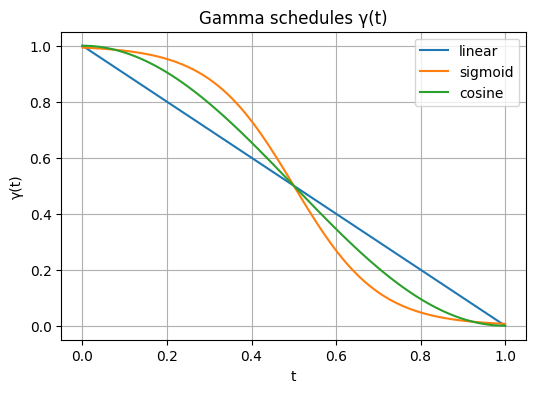

In [ ]:
t_vals = torch.linspace(0, 1, 100)

plt.figure(figsize=(6, 4))
plt.plot(t_vals, gamma_linear(t_vals), label="linear")
plt.plot(t_vals, gamma_sigmoid(t_vals), label="sigmoid")
plt.plot(t_vals, gamma_cosine(t_vals), label="cosine")
plt.title("Gamma schedules γ(t)")
plt.xlabel("t")
plt.ylabel("γ(t)")
plt.legend()
plt.grid(True)
plt.show()

### Noising

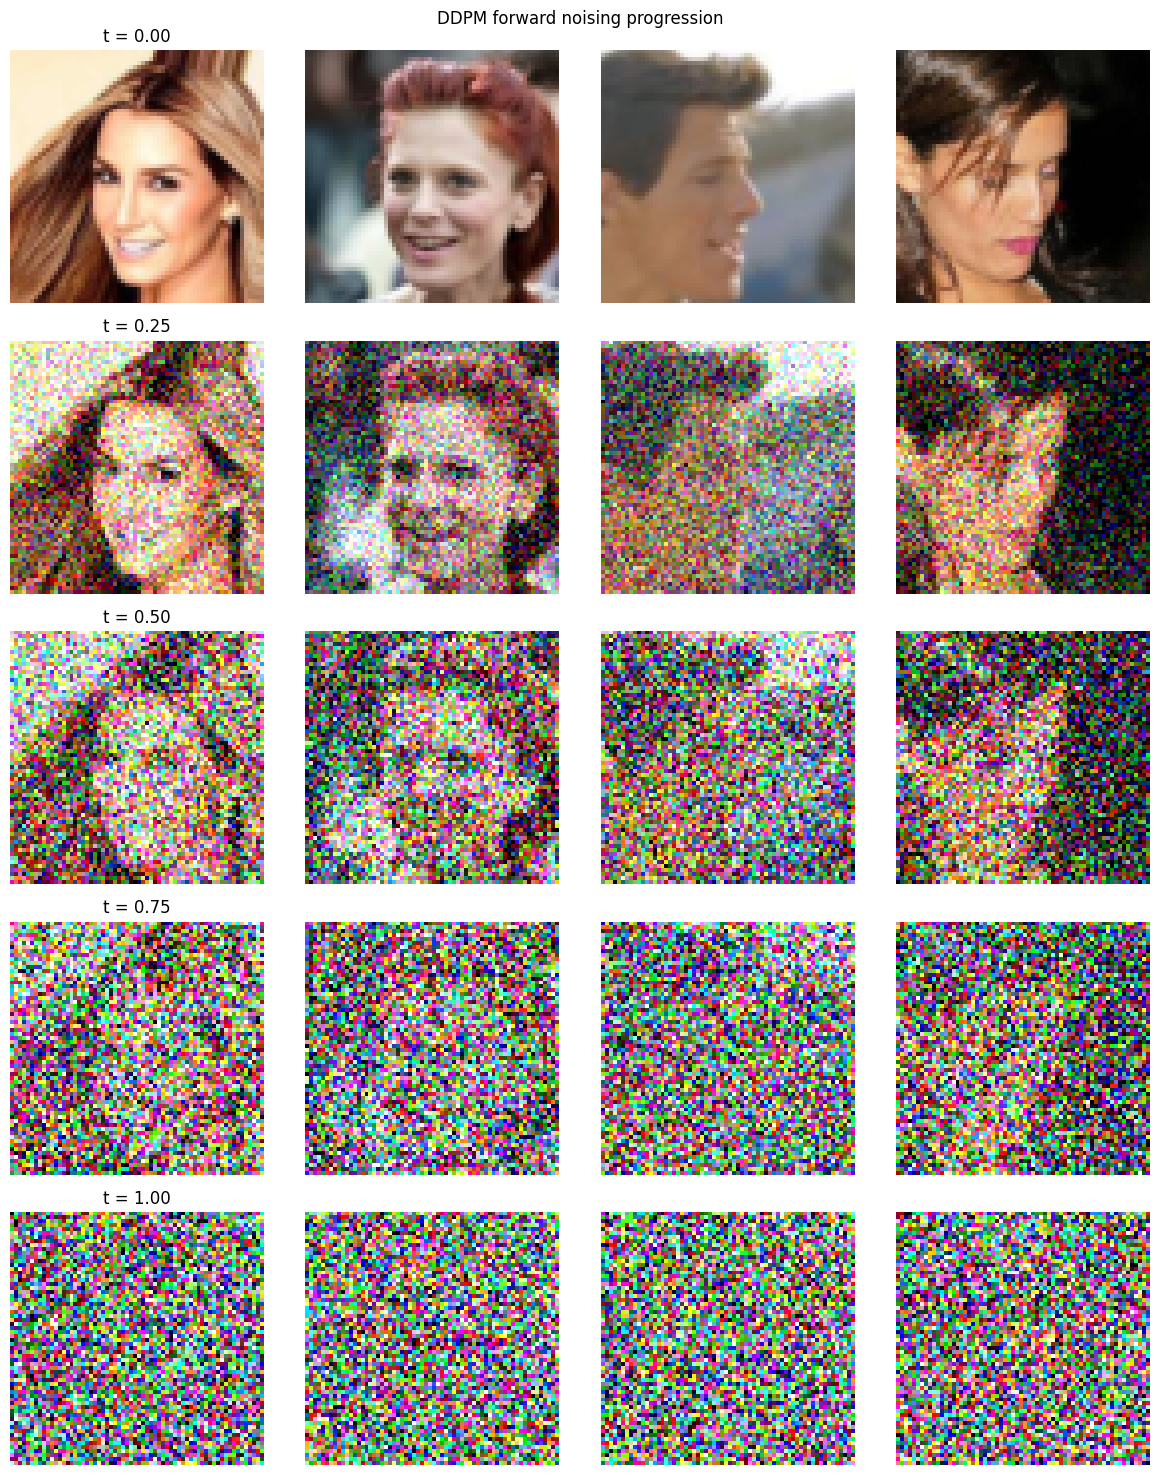

In [3]:
# Load dataset
data_module = CelebADataModule(data_dir="./data", image_size=64, batch_size=4, num_workers=0)
data_module.prepare_data()
data_module.setup()
dataset = data_module.train_dataloader().dataset

batch_size = 4
images = torch.stack([dataset[i][0] for i in range(batch_size)])  # (4, 3, 64, 64)


# Show images
def show_images(images, title):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 4))
    for i, ax in enumerate(axes):
        img = images[i].permute(1, 2, 0)  # CHW → HWC
        img = (img + 1) / 2.0  # denormalize
        ax.imshow(img.clamp(0, 1))
        ax.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


# Visualize noising
timesteps = [0.0, 0.25, 0.5, 0.75, 1.0]
gamma_fn = gamma_cosine

fig, axes = plt.subplots(len(timesteps), batch_size, figsize=(batch_size * 3, len(timesteps) * 3))

for row, t_val in enumerate(timesteps):
    # Fixed t shape: [B, 1, 1, 1]
    t = torch.full((batch_size, 1, 1, 1), t_val, device=images.device)
    x_t, _ = forward_noise(images, t, gamma_fn)  # [B, 3, 64, 64]

    for col in range(batch_size):
        img = x_t[col].permute(1, 2, 0).detach().cpu()  # [3, 64, 64] → [64, 64, 3]
        img = (img + 1) / 2.0  # map from [-1, 1] to [0, 1]
        axes[row, col].imshow(img.clamp(0, 1))
        axes[row, col].axis("off")
        if col == 0:
            axes[row, col].set_title(f"t = {t_val:.2f}")

plt.suptitle("DDPM forward noising progression")
plt.tight_layout()
plt.show()